# 1. Setup

In [1]:
from functools import reduce
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.animation import FuncAnimation
from pqdm.processes import pqdm
from shapely.geometry import Polygon

from utils import *

## 1.1. Zones

In [2]:
zonesIN = gpd.read_parquet(
    DATA / 'zones/zones_2020.parquet',
    columns=['geoid', 'scale', 'county', 'urba', 'geometry'],
    filters=[('state', '==', 'IN'), ('aland', '>', 0)]).disp(0) # 9s

7,072 rows x 5 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,urba,geometry
,<object>,<category>,<category>,<category>,<geometry>


## 1.2. SES

In [3]:
ses = pd.read_parquet(DATA / 'ses/ses.parquet').disp()

325,010 rows x 33 cols; Memory: 78.2 MiB


,geoid,scale,popu,house,labor,pop_density,house_density,p_minor,p_poc,p_lowenglish,...,p_nowfh,p_transit,p_walkbike,svi,svi_ses,svi_hh,svi_race,svi_trans,adi_nat,setdi
,<object>,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,01001,County,58239.0,57692.0,27550.0,97.97068,97.050507,0.18,0.248699,0.002312,...,0.952604,0.005713,0.009721,NaN,NaN,NaN,NaN,NaN,NaN,0.385457


## 1.3. Accessibility

In [4]:
xsIN = pd.read_parquet(DATA / 'access/base/indiana.parquet')
purpose = xsIN.pop('purpose').astype(str).map({
    'Work': ' jobs', 'Non-work': ' POIs'})
xsIN.kind = (xsIN.kind.astype(str) + purpose).astype(CAT)
xsIN.disp(); pass

3,496,399 rows x 7 cols; Memory: 37.4 MiB


,measure,kind,mode,thresh,scale,geoid,access
,<category>,<category>,<category>,<category>,<category>,<category>,<float32>
0,Contour,All jobs,Bike,15,BG,180010301001,90.0


In [5]:
xsIN2 = pd.read_parquet(DATA / 'access/derived/indiana.parquet').disp(0)

3,570,660 rows x 7 cols; Memory: 38.2 MiB


,measure,mode,thresh,scale,geoid,kind,access
,<category>,<category>,<category>,<category>,<category>,<category>,<float32>


In [6]:
xsMaxIN = pd.read_parquet(DATA / 'access/max/indiana.parquet').disp(0)

3,496,399 rows x 8 cols; Memory: 40.7 MiB


,measure,purpose,kind,mode,thresh,scale,geoid,access
,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<float32>


In [7]:
def filterXs(xs=xsIN, **kw):
    query = ' & '.join([f'{k}=="{v}"' for k, v in kw.items()])
    return xs.query(query).drop(columns=list(kw)).reset_index(drop=1)

# filterXs(scale='Tract', purpose='Work')

# 2. Visualize

In [8]:
def plot_IN(df, var, ax=None, zones=zonesIN, fill=False, rank=False,
            cmap='rainbow', vmin=None, vmax=None,
            shrink=0.4, title=None, label=None):
    df = zones[['geoid', 'geometry']].merge(df, 'left')
    if fill: df[var] = df[var].fillna(0)
    if rank: df[var] = df[var].rank(pct=True)
    ax = ax or pplot(size=(6, 12), dpi=150, axoff=1, title=title)
    df.plot(var, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
            legend_kwds=D(shrink=shrink, label=label))
    zones.query('scale=="County"').plot(ax=ax, fc='none', ec='k', lw=0.5)

## 2.1. All Indiana maps

In [13]:
def fig_xs_unique(query: dict, xs=xsIN, cmap='rainbow_r',
                  rank=True, show=False, save=True):
    df = filterXs(xs=xs, **query)
    if len(df) == 0: return
    if rank: df.access = df.access.rank(pct=True)
    title = '\n'.join([f'{k}={v}' for k, v in query.items()])
    ax = pplot(size=(6, 12), axoff=1, title=title)
    label = 'Access' + (' quantile' if rank else '')
    plot_IN(df, 'access', ax=ax, cmap=cmap, label=label)
    if save:
        outpath = FIG / 'indiana/combinations'
        imsave(title.replace('\n', ''), dpi=150, root=outpath)
    if not show: plt.close()

# fig_xs_unique(D(scale='Tract', mode='Drive', measure='Gravity',
#                 kind='All jobs', thresh='45'), show=1) # 4s

In [10]:
grpCols = ['kind', 'scale', 'measure', 'mode', 'thresh']
combs = [D(zip(grpCols, x)) for x in it.product(
    *[xsIN[var].cat.categories for var in grpCols])]
# fig_xs_unique(combs[0], show=True)
# pqdm(combs, fig_xs_unique, n_jobs=36); # 1m28s

## 2.2. Comparing measures

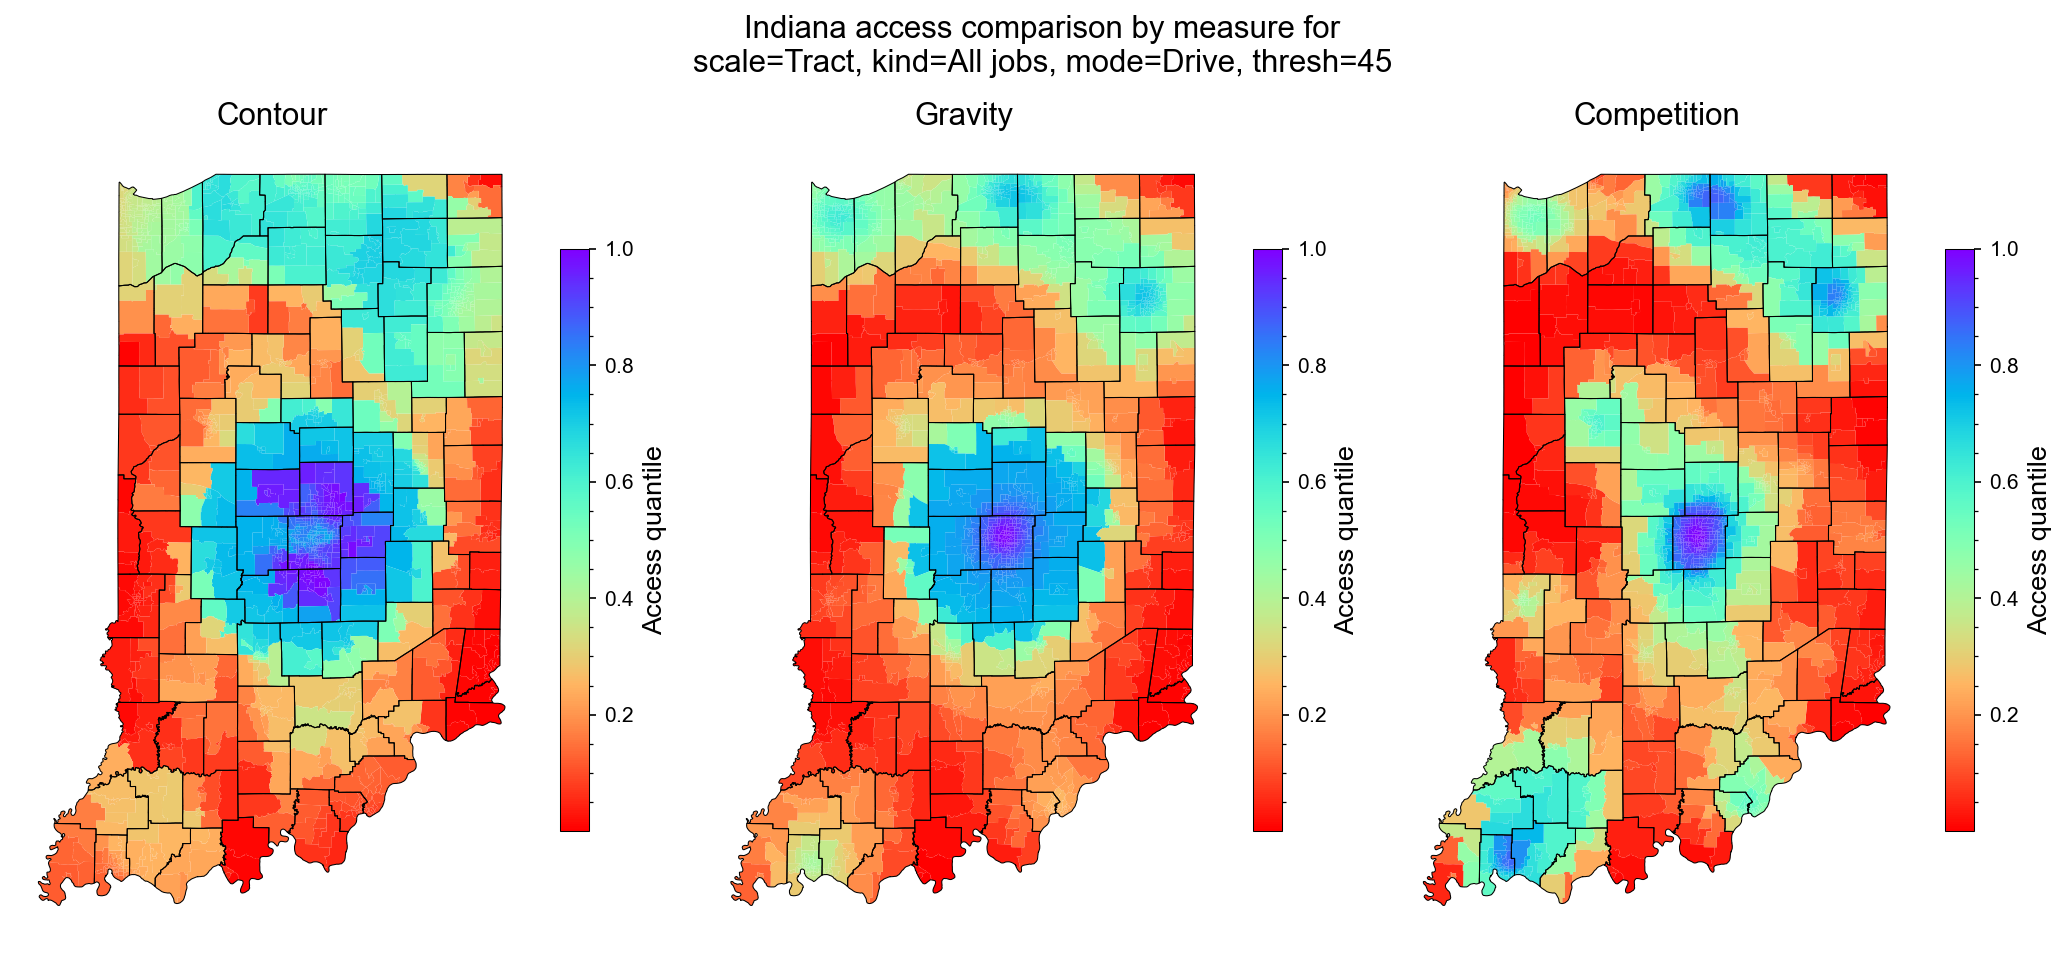

In [11]:
def fig_xs_by_measure(query: dict, rank=True, cmap='rainbow_r'):
    _, axes = plt.subplots(1, 3, figsize=(14, 10), dpi=150)
    for i, measure in enumerate(['Contour', 'Gravity', 'Competition']):
        df = filterXs(measure=measure, **query)
        if rank: df.access = df.access.rank(pct=True)
        ax = pplot(axes[i], axoff=1, title=measure)
        plot_IN(df, 'access', ax=ax, cmap=cmap, label='Access quantile')
    title = ('Indiana access comparison by measure for\n' +
             ', '.join([f'{k}={v}' for k, v in query.items()]))
    plt.tight_layout()
    plt.suptitle(title, y=0.85)
    imsave(title)

fig_xs_by_measure(D(scale='Tract', kind='All jobs', mode='Drive', thresh='45')) # 4s

In [12]:
# for th in tqdm([15, 30, 45, 60, 90]):
#     fig_xs_by_measure(D(scale='Tract', kind='All jobs', mode='Drive', thresh=str(th)))

## 2.3. Access vs urbanity

In [15]:
def plot_xs_vs_urbanity(xs=xsIN, ses=ses, size=(15, 10), dpi=150):
    xs = filterXs(xs, scale='Tract', kind='All jobs', mode='Drive',
                  thresh='45', measure='Competition')
    df = xs.merge(ses[['geoid', 'popu', 'pop_density']])
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    ax = pplot(size=(6, 12), axoff=1, title=title)
    label = 'Access' + (' quantile' if rank else '')
    plot_IN(df, 'access', ax=ax, cmap=cmap, label=label)
    return df

x = plot_xs_vs_urbanity(); x

,geoid,access,popu,pop_density
0,18001030100,0.672834,4826.0,62.160343
1,18001030200,0.641037,4652.0,495.652863
2,18001030300,0.576541,5408.0,568.418274
3,18001030400,0.570521,4063.0,56.189327
4,18001030500,0.505325,6789.0,80.892899
...,...,...,...,...
1682,18183050401,0.904690,3409.0,2232.335449
1683,18183050402,0.915992,4669.0,342.976807
1684,18183050500,0.885145,5106.0,161.114288
1685,18183050600,0.982393,2216.0,66.223267


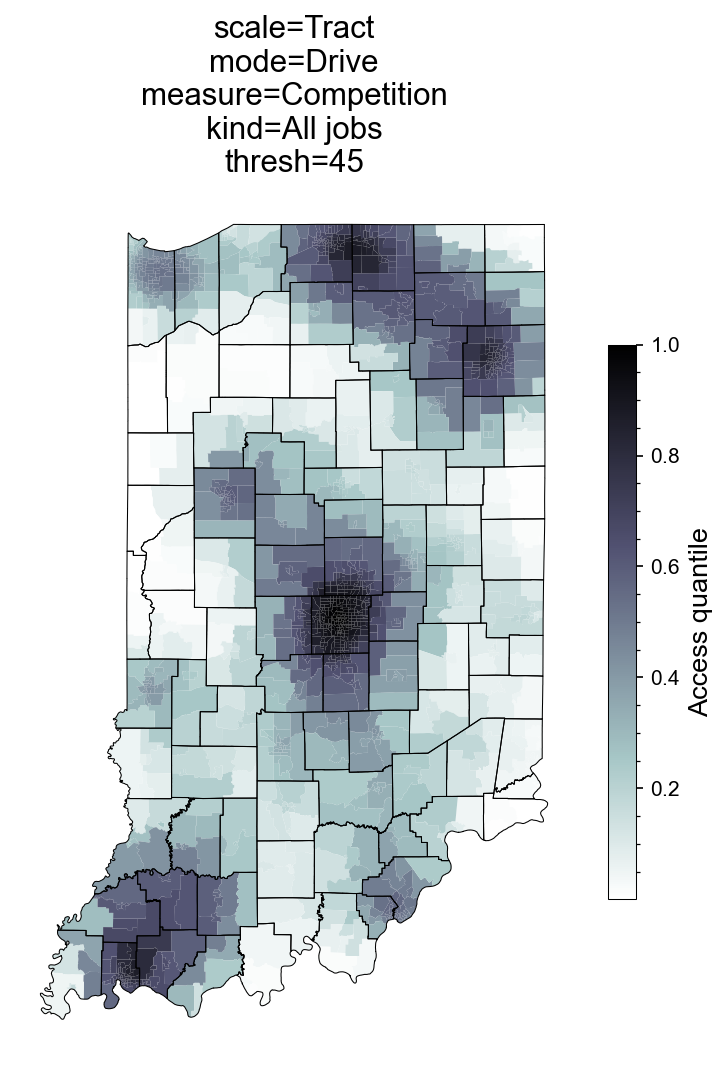

In [14]:
fig_xs_unique(D(scale='Tract', mode='Drive', measure='Competition',
                kind='All jobs', thresh='45'), show=1, cmap='bone_r')

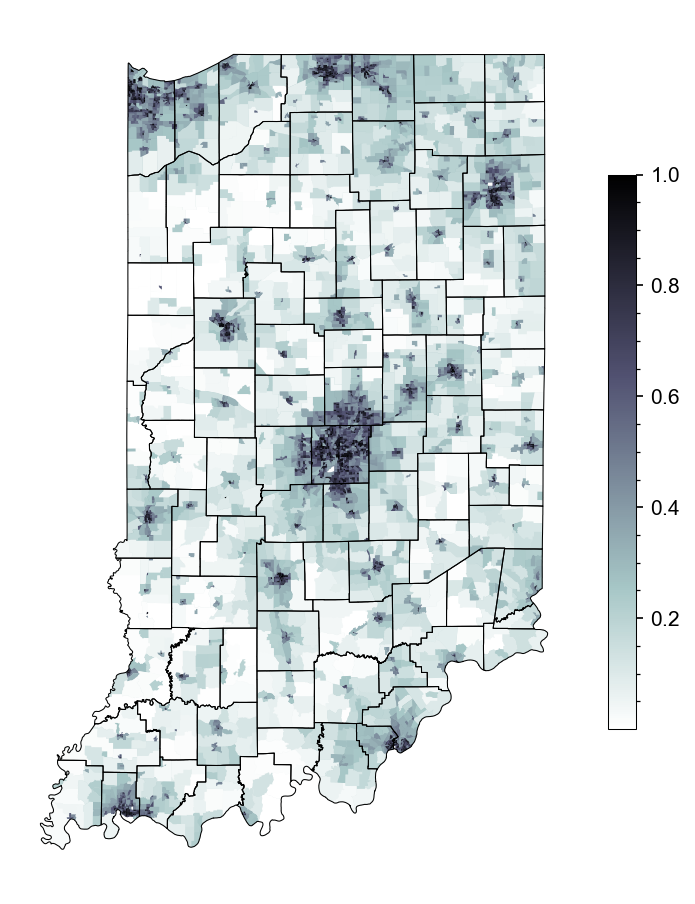

In [18]:
plot_IN(ses, 'pop_density', cmap='bone_r', rank=1)

In [27]:
from sklearn.linear_model import LinearRegression

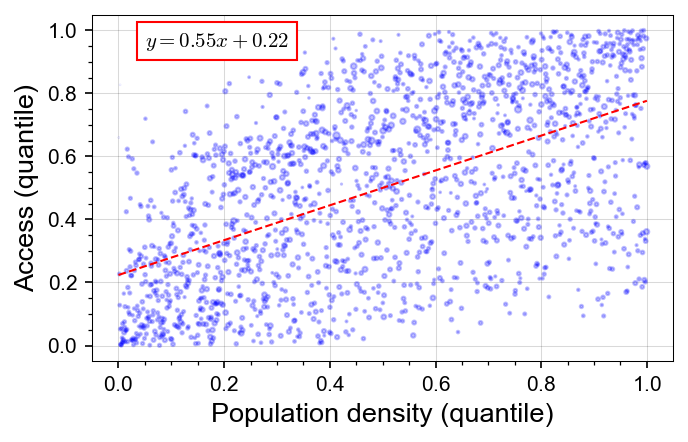

In [34]:
df = (filterXs(scale='Tract', mode='Drive', measure='Competition', kind='All jobs', thresh='45')
      .merge(ses.query('scale=="Tract"')[['geoid', 'popu', 'pop_density']]))
for col in ['pop_density', 'access']: df[col] = df[col].rank(pct=True)
ax = pplot(size=(5, 3), xlab='Population density (quantile)', ylab='Access (quantile)')
ax.scatter(df.pop_density, df.access, s=10 * normalize(df.popu), alpha=0.25, color='b')
reg = LinearRegression().fit(df[['pop_density']], df['access'])
m, c = reg.coef_[0], reg.intercept_
x = np.linspace(0, 1, 100)
y = m * x + c
ax.plot(x, y, ls='--', color='r', lw=1)
ax.text(0.05, 0.95, '$y=%.2f x + %.2f$' % (m, c), bbox=D(fc='w', ec='r'));

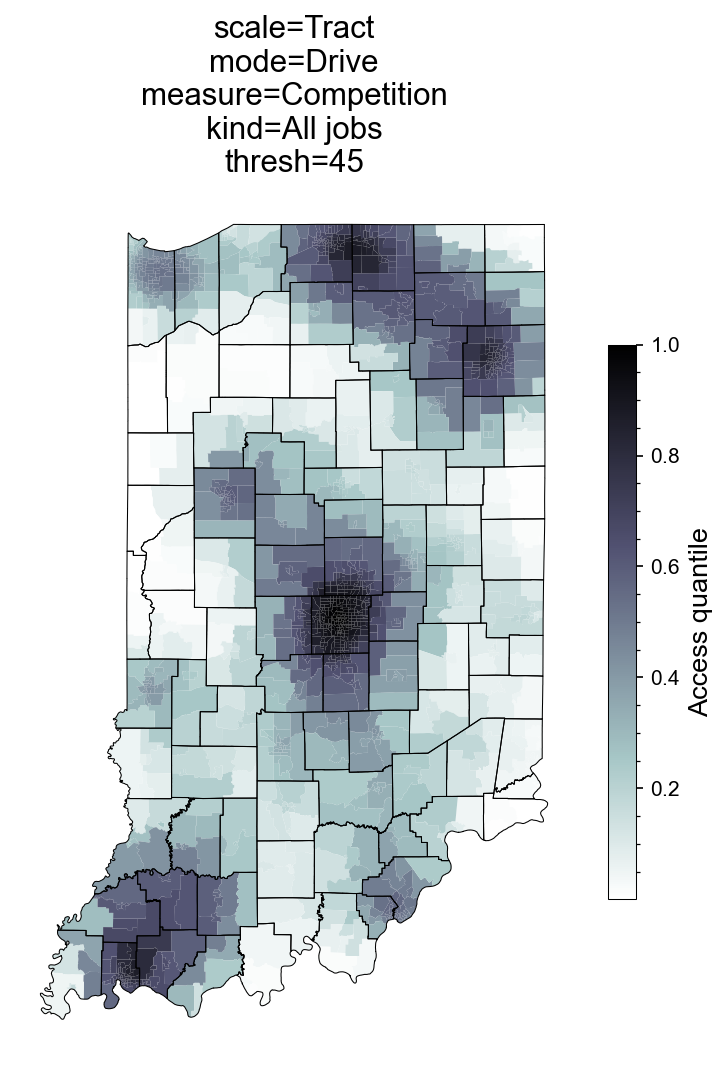

In [ ]:
fig_xs_unique(D(scale='Tract', mode='Drive', measure='Competition',
                kind='All jobs', thresh='45'), show=1, cmap='bone_r')

## 2.4. Accessibility heatmap

## 2.5. By purpose

### 2.5.1. Distributions

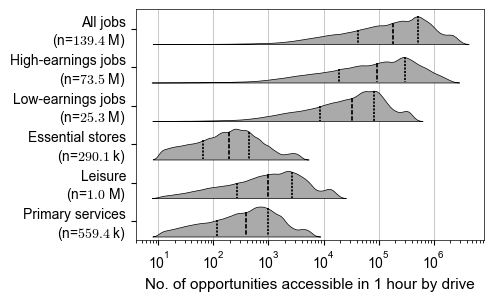

In [11]:
def plot_access_by_purpose(xs=xs_st, opport=opport, size=(4.5, 3), dpi=100):
    ax = pplot(size=size, dpi=dpi, xlog=1)
    purposes = D(total='All jobs', high_earn='High-earnings jobs', 
                 low_earn='Low-earnings jobs', shopping='Essential stores',
                 leisure='Leisure', services='Primary services')
    opport = (opport.groupby('kind')['opport'].sum().reset_index()
              .assign(purpose=lambda df: df.kind.map(purposes))
              .dropna().set_index('purpose').loc[list(purposes.values())]
              .reset_index().rename_axis('pid').reset_index())
    opport['purpose'] = ['{}\n(n={})'.format(
        r.purpose, mpl.ticker.EngFormatter(places=1)(r.opport)) 
                         for _, r in opport.iterrows()]
    xs = xs[['kind', 'access', 'geoid']].query('access > 10')
    xs = xs.merge(opport, on='kind').sort_values('pid').astype(D(purpose=CAT))
    xs.purpose = pd.Categorical(xs.purpose, categories=opport.purpose)
    ax = sns.violinplot(xs, y='purpose', x='access', hue=True,
                        hue_order=[True, False], split=True,
                        palette=sns.color_palette(['#aaa', 'w']),
                        inner='quart', legend=False, edgecolor='k')
    ax.set_xlabel('No. of opportunities accessible in 1 hour by drive', fontsize=11)
    ax.set_ylabel(''); ax.grid(color='k', alpha=0.3, axis='x')
    ax.tick_params(axis='y', which='minor', width=0)
    for x in ax.collections:
        x.set_linewidth(0.5)
    ax.patch.set_alpha(0)

plot_access_by_purpose(dpi=100) # t=0:07

### 2.5.2. Map (USA)

In [ ]:
def plot_access_by_purpose(xs=xs_st, counties=us_counties, 
                           states=us_states, size=(10, 4), dpi=100):
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs = xs.assign(cnty=xs.geoid.str[:5]).copy()
    idx18 = xs[(xs.region.isin(['arkansas', 'mississippi'])) 
               & (xs.kind == 'high_earn')].index
    xs.loc[idx18, 'access'] *= 1.3
    xs = xs[xs.kind.isin(['low_earn', 'high_earn'])].copy()
    popu = (pd.read_parquet(DATA / 'ses/acs_2021.parquet')
            .query('scale=="bg"')[['geoid', 'popu']])
    xs = xs.merge(popu)
    xs['access'] *= xs.popu
    xs = (xs.astype(D(kind=str)).groupby(['kind', 'cnty'])
          [['access', 'popu']].sum().reset_index())
    xs = xs.pivot_table('access', 'cnty', 'kind')
    xs['ratio'] = xs.low_earn / xs.high_earn
    xs = counties.merge(xs, on='cnty')
    label = 'Ratio of low-earnings to high-earnings job accessibility'
    xs.plot(ax=ax, column='ratio', cmap='Spectral_r', legend=True, legend_kwds=D(
        shrink=0.4, orientation='horizontal', label=label, pad=0.02, extend='both'), 
            vmin=0.2, vmax=1)
    states.plot(ax=ax, fc='none', ec='k', lw=0.8)

plot_access_by_purpose(dpi=100) # t=0:03

## 2.6. Flat cutoff vs decay

In [13]:
def get_flat_vs_decay(level, rgn, kind, mode, thresh, 
                      opport=opport, params=imped_params):
    purpose = 'work' if kind in ['total', 'low_earn', 'high_earn'] else kind
    params = params.query(f'mode=="{mode}" & purpose=="{purpose}"')
    alpha, beta = params.iloc[0].alpha, params.iloc[0].beta
    tt = pd.read_parquet(DATA / 'od_cost/osrm/{}/{}/bg_{}_2020.parquet'
                         .format(level, rgn, mode), filters=[
                             ('duration', '<=', thresh * 60)])
    tt['decay'] = np.exp(-alpha * (tt.duration / 60) ** beta)
    df = opport.query(f'kind=="{kind}"')[['geoid', 'opport']]
    wt = tt.assign(flat=1).merge(df, left_on='trg_geoid', right_on='geoid')
    for col in ['flat', 'decay']: wt[col] *= wt['opport']
    xs = (wt.groupby('src_geoid')[['flat', 'decay']].sum()
          .rename_axis('geoid').reset_index())
    xs['pct_increase'] = (xs.flat / xs.decay - 1) * 100
    return xs

chi_flat_vs_decay = pd.concat([
    get_flat_vs_decay('msa', 'chicago', 'total', 'drive', t)
    .assign(thresh=t) for t in tqdm([15, 30, 45, 60, 90])
]).dropna().disp() # 33s

  0%|          | 0/5 [00:00<?, ?it/s]

33,614 rows x 5 cols; Memory: 2.0 MiB


,geoid,flat,decay,pct_increase,thresh
,<category>,<int64>,<float64>,<float64>,<int64>
0,170310101001,237098,187842.421273,26.221755,15


In [15]:
indy_flat_vs_decay = pd.concat([
    get_flat_vs_decay('msa', 'indianapolis', 'total', 'drive', t)
    .assign(thresh=t) for t in tqdm([15, 30, 45, 60, 90])
]).dropna().disp() # 2s

  0%|          | 0/5 [00:00<?, ?it/s]

7,160 rows x 5 cols; Memory: 0.4 MiB


,geoid,flat,decay,pct_increase,thresh
,<category>,<int64>,<float64>,<float64>,<int64>
0,180118101001,11990,9656.944885,24.15935,15


In [ ]:
def plot_flat_vs_decay(xs=indy_flat_vs_decay, dpi=100):
    bg = gpd.read_parquet(DATA / 'zones/msa_2020.parquet', filters=[
        ('region', '==', 'indianapolis'), ('scale', '==', 'bg')],
                          columns=['geoid', 'geometry']).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg.merge(us_counties[['cnty', 'county']])
    bg = bg[bg.county != 'DeKalb']
    cnty = bg[['cnty', 'geometry']].dissolve('cnty').reset_index()
    xs = bg[['geoid', 'geometry']].merge(xs, on='geoid')
    xs60 = xs.query('thresh==60')
    ## Panels A & B
    fig, axes = plt.subplots(1, 2, figsize=(6, 4.5), dpi=dpi)
    for i, (col, cmap, vmax, label) in enumerate([
            ('decay', 'pink_r', .5e6, 'Total accessible opportunities'),
            ('pct_increase', 'bone_r', 800, 'Percent increase in accessibility')]):
        ax = xs60.plot(ax=axes[i], column=col, cmap=cmap, legend=True,
                       vmin=0, vmax=vmax, legend_kwds=D(
                           label=label, format=mpl.ticker.EngFormatter(), pad=0.04,
                           shrink=0.8, orientation='horizontal', extend='max'))
        ax.tick_params(left=0, right=0, labelleft=0, labelbottom=0, bottom=0)
        ax.add_artist(ScaleBar(0.3))
        cnty.plot(ax=ax, fc='none', ec='k', lw=1)
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
    fig.subplots_adjust(wspace=0)
    fig.tight_layout()
    ## Panel C
    ax = pplot(size=(2.5, 4.2), dpi=dpi, ylim=(0, 800))
    ax = sns.boxplot(xs, ax=ax, x='thresh', y='pct_increase', 
                     palette='rainbow', fliersize=2, gap=0.2)
    avg_xs = xs.groupby('thresh')['pct_increase'].mean().reset_index(drop=1)
    avg_xs.plot(ax=ax, ls='--', lw=0.8, marker='.', color='k')
    ax.set_xlabel('Duration threshold (min)', fontsize=12)
    ax.set_ylabel('Percent increase')
    ax.minorticks_off()

%time plot_flat_vs_decay(dpi=250) # 10s

## 2.7. Access efficiency

In [15]:
test_msas = (
    ('houston', ['Harris']),
    ('new-york', ['New York', 'Bronx', 'Queens', 'Kings', 'Richmond']),
    ('chicago', ['Cook', 'DuPage']),
    # ('indianapolis', ['Marion']),
    # ('minneapolis', ['Hennepin', 'Ramsey']),
    # ('columbus', ['Franklin'])    
)

In [16]:
def plot_efficiency(level, rgn, counties=[], thresh=60, mode='drive', 
                    kind='total', us_counties=us_counties,
                    size=(8, 8), dpi=150, cmap='gnuplot',
                    vmin=None, vmax=None, alpha=1):
    bg = gpd.read_parquet(DATA / f'zones/{level}_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', rgn)
    ], columns=['geoid', 'geometry']).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg.merge(us_counties[['cnty', 'county']])
    if counties: bg = bg[bg.county.isin(counties)]
    cnty = us_counties[us_counties.cnty.isin(bg.cnty)]
    xs = pd.merge(*[
        pd.read_parquet(DATA / f'access/{label}{level}_2020.parquet', filters=[
            ('region', '==', rgn), ('thresh', '==', str(thresh)),
            ('mode', '==', mode), ('kind', '==', kind)],
                        columns=['geoid', 'access'])
        .rename(columns=D(access=xs_kind))
        for xs_kind, label in [('observed', ''), ('maximum', 'max_')]
    ], on='geoid').assign(pct=lambda df: df['observed'] / df['maximum'] * 100)
    xs = bg.merge(xs, on='geoid')
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs.plot(ax=ax, column='pct', legend=True, cmap=cmap, vmin=vmin, vmax=vmax,
            legend_kwds=D(shrink=0.7, label='Efficiency (\%)'), alpha=alpha)
    cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
    ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
    ax.add_artist(ScaleBar(0.3))

In [17]:
# x = plot_efficiency('msa', 'indianapolis', ['Marion'], 30, alpha=0.75, vmin=20, vmax=50, cmap='Spectral'); x

In [18]:
# plot_efficiency('msa', 'chicago', ['Lake', 'Porter', 'Jasper', 'Newton'], 30, alpha=0.75, vmin=0, vmax=30, cmap='Spectral')

In [19]:
# plot_efficiency('state', 'indiana', [], 60, vmin=0, vmax=50)

### 2.7.1. Test cities

In [ ]:
def plot_access_efficiency_map(msas=test_msas, obs_xs=xs_msa, max_xs=xs_max_msa,
                               thresh=30, vmin=0, vmax=50, us_counties=us_counties,
                               widths=(1.1, 0.8, 0.8), size=(16, 15), dpi=100, cmap='gnuplot'):
    fig, axes = plt.subplots(3, 3, figsize=size, dpi=dpi, gridspec_kw=D(width_ratios=widths))
    for j, (rgn, counties) in enumerate(tqdm(msas)):
        zones = gpd.read_parquet(DATA / 'zones/msa_2020.parquet', filters=[
            ('scale', '==', 'bg'), ('region', '==', rgn), ('aland', '>', 0)],
                                 columns=['geoid', 'geometry'])
        zones['cnty'] = zones.geoid.str[:5]
        zones = zones.merge(us_counties[['cnty', 'county']], on='cnty')
        zones = zones[zones.county.isin(counties)].to_crs(CRS_M)
        cnty = us_counties.merge(zones[['cnty']].drop_duplicates())
        popu = pd.read_parquet(DATA / 'ses/acs_2021.parquet', filters=[
            ('scale', '==', 'bg')], columns=['geoid', 'popu'])
        zones = zones.merge(popu, on='geoid')
        zones['popu_wt'] = zones['popu'] / zones['popu'].sum()
        for i, mode in enumerate(['drive', 'bike', 'walk']):
            xs = pd.merge(*[
                df.query(f'region=="{rgn}" & thresh=="{thresh}" & '
                         f'kind=="total" & mode=="{mode}"')
                [['geoid', 'access']].rename(columns=D(access=xs_kind))
                for xs_kind, df in [('observed', obs_xs), ('maximum', max_xs)]
            ], on='geoid')
            xs['pct'] = xs['observed'] / xs['maximum'] * 100
            if mode == 'walk': xs.pct[xs.pct > vmax] = np.nan
            xs = zones.merge(xs[['geoid', 'pct']])
            ax = pplot(axes[i, j], axoff=1)
            xs.plot(ax=ax, column='pct', legend=j == 2, cmap=cmap, 
                    vmin=vmin, vmax=vmax, legend_kwds=D(
                        shrink=0.7, extend='max', label='Percent of maximum accessibility'))
            cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
            ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
            ax.add_artist(ScaleBar(0.3))
    fig.subplots_adjust(wspace=0.02, hspace=0.02)

# plot_access_efficiency_map(dpi=250, cmap='gist_earth_r') # 40s

  0%|          | 0/3 [00:00<?, ?it/s]

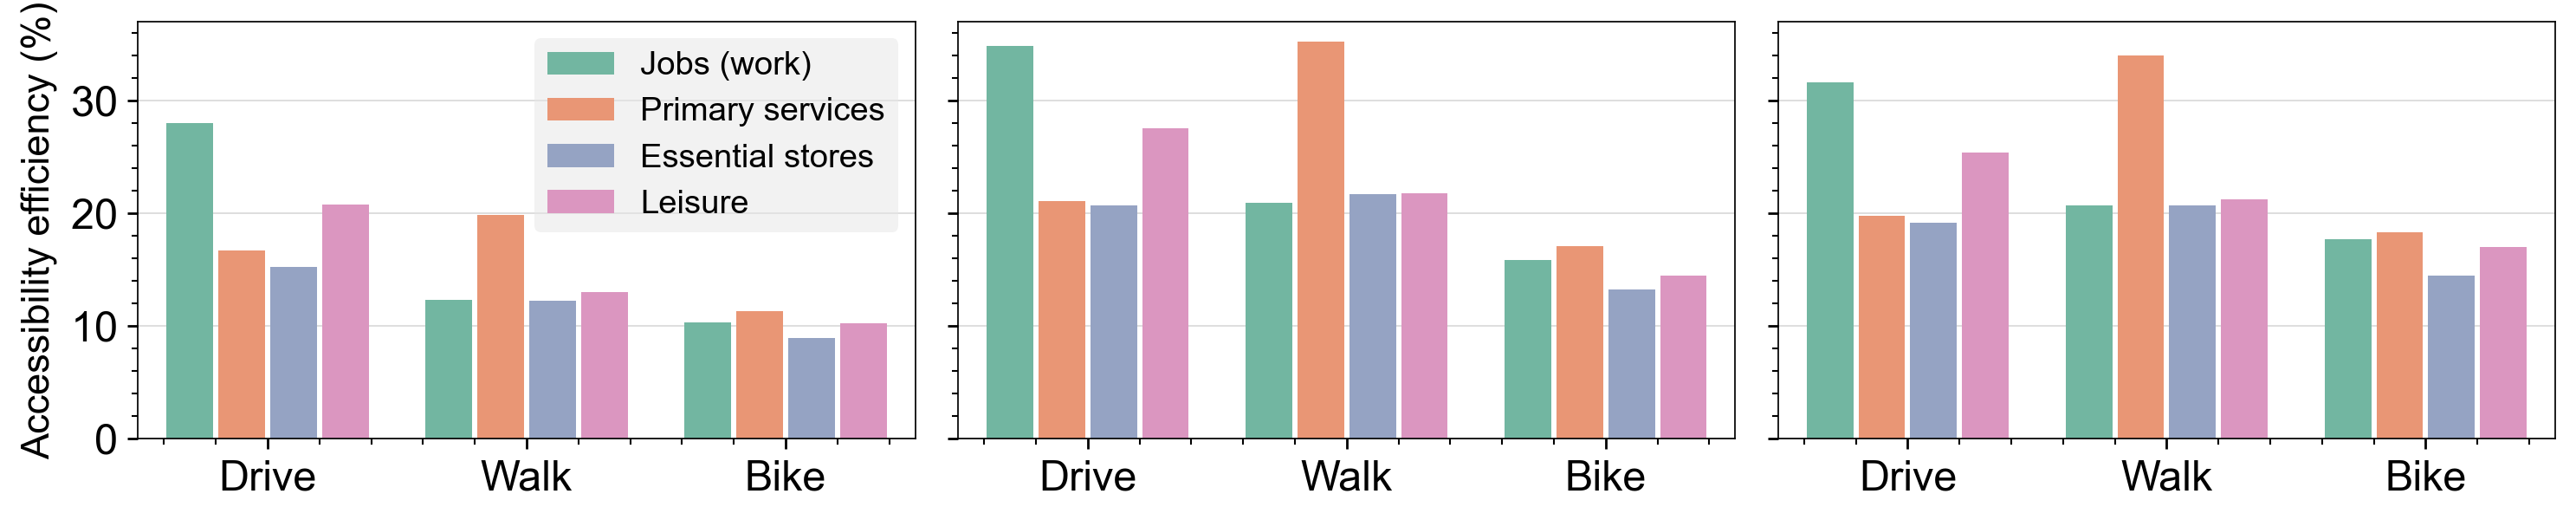

In [21]:
def plot_access_efficiency_bar(msas=test_msas, obs_xs=xs_msa, max_xs=xs_max_msa,
                               us_counties=us_counties, size=(12, 2.5), dpi=100):
    purposes = D(total='Jobs (work)', services='Primary services',
                 shopping='Essential stores', leisure='Leisure')
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi, sharey=True)
    for j, (rgn, filt_counties) in enumerate(tqdm(msas)):
        zones = gpd.read_parquet(DATA / 'zones/msa_2020.parquet', filters=[
            ('scale', '==', 'bg'), ('region', '==', rgn), ('aland', '>', 0)],
                                 columns=['geoid', 'geometry'])
        zones['cnty'] = zones.geoid.str[:5]
        zones = zones.merge(us_counties[['cnty', 'county']], on='cnty')
        zones = zones[zones.county.isin(filt_counties)].to_crs(CRS_M)
        popu = pd.read_parquet(DATA / 'ses/acs_2021.parquet', filters=[
            ('scale', '==', 'bg')], columns=['geoid', 'popu'])
        zones = zones.merge(popu, on='geoid')
        zones['popu_wt'] = zones['popu'] / zones['popu'].sum()
        xs = pd.merge(*[df.query(f'region=="{rgn}" & thresh=="30"')
                        .rename(columns=D(access=xs_kind))
                        [['kind', 'mode', 'geoid', xs_kind]]
                        for xs_kind, df in [('observed', obs_xs), ('maximum', max_xs)]
                        ], on=('kind', 'mode', 'geoid'))
        xs = zones[['geoid', 'popu_wt', 'geometry']].merge(xs, on='geoid')
        xs = xs.assign(kind=xs.kind.map(purposes), mode=xs['mode'].str.title()).dropna()
        xs['observed'] *= xs['popu_wt']
        xs['maximum'] *= xs['popu_wt']
        effic = xs.groupby(['kind', 'mode'])[['observed', 'maximum']].sum()
        effic = (effic['observed'] / effic['maximum'] * 100).rename('eta').reset_index()
        sns.barplot(effic, x='mode', y='eta', hue='kind', ax=axes[j],
                    palette='Set2', legend=j == 0, gap=0.1, alpha=1, 
                    order=['Drive', 'Walk', 'Bike'], hue_order=purposes.values())
        ax = pplot(axes[j], xlab='', ylab='Accessibility efficiency (%)' if j == 0 else '')
        ax.tick_params(labelsize=14)
        leg = ax.get_legend()
        if leg: leg.set_title('')
        plt.tight_layout()

plot_access_efficiency_bar(dpi=250) # 9s

In [ ]:
def plot_access_efficiency_map_us(obs_xs=xs_st, max_xs=xs_max_st, kind='total',
                                  vmin=0, vmax=50, size=(16, 8), dpi=100,
                                  counties=us_counties, states=us_states):
    obs_xs = (obs_xs.query(f'kind=="{kind}"')[['geoid', 'access']]
              .rename(columns=D(access='obs')))
    max_xs = (max_xs.query(f'kind=="{kind}"')[['geoid', 'access']]
              .rename(columns=D(access='max')))
    xs = pd.merge(obs_xs, max_xs, on='geoid')
    popu = pd.read_parquet(DATA / 'ses/acs_2021.parquet', filters=[
        ('scale', '==', 'bg')], columns=['geoid', 'popu'])
    xs = xs.merge(popu, on='geoid')
    xs.geoid = xs.geoid.str[:5]
    for col in ['obs', 'max']: xs[col] *= xs['popu']
    xs = xs.groupby('geoid')[['obs', 'max']].sum().reset_index()
    xs['pct'] = xs['obs'] / xs['max'] * 100
    xs = counties.merge(xs, left_on='cnty', right_on='geoid')
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs.plot(ax=ax, column='pct', vmin=vmin, vmax=vmax, cmap='bone_r', 
            legend=True, legend_kwds=D(
                orientation='horizontal', shrink=0.3, pad=0,
                label='Accessibility efficiency (%)'))
    states.plot(ax=ax, fc='none', ec='k', lw=1)
    ax.add_artist(ScaleBar(0.2))

x = plot_access_efficiency_map_us(dpi=100); x # t=0:04